## Handwritten Digit Recognizer with MNIST Data Set
### Arash Tavassoli - May 2019
---
## 1. Introduction
In this project we look at the MNIST data set, which is a Modified version of the data from the National Institute of Standards and Technology.

The dataset is a collection of labelled handwritten digits from Census Bureau employees and High School Students (numbers 0-9). When provided with unlabelled digits, the challenge is to determine which digits they were.

Original data source: http://yann.lecun.com/exdb/mnist/

## 2. Objectives
The main objective is to try different machine learning models and compare their performance in predicting handwritten digits.

## 3. Preprocessing
Let's start by loading all the libraries that we'll need in the course of this project:

In [80]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import time
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

We can now load the data as a NumPy array (images have already been converted to a CSV file), split the features and the response and do a train-test split:

In [81]:
mnist_csv = np.genfromtxt("mnist_data.csv", delimiter=",")

# Split into features and response
X = mnist_csv[:, :-1]
y = mnist_csv[:, -1]

In [82]:
# Split into train & test sets (with test_size = 40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state = 1)

Let's do a few quick checks on the datasets:

In [83]:
## Save the number of samples (m):
m_train = y_train.shape[0]
m_test = y_test.shape[0]
print(f'The number of training exmaples:\t{m_train}')
print(f'The number of test exmaples:\t\t{m_test}\n')

# Check X and Y value ranges (across entire dataset):
print(f'The min/max y value across train and test sets:\t{y.min(), y.max()}')
print(f'The min/max X value across train and test sets:\t{X.min(), X.max()}')

The number of training exmaples:	21000
The number of test exmaples:		14000

The min/max y value across train and test sets:	(0.0, 9.0)
The min/max X value across train and test sets:	(0.0, 255.0)


In [84]:
# Check for NaNs (across entire dataset):
np.isnan(mnist_csv).any()

False

In [85]:
# Checking number of features:
print(f'Number of features (total pixels in each image): {X.shape[1]}')

Number of features (total pixels in each image): 784


In [86]:
# Calculating the image dimensions (number of pixels, assuming it's square):
np.sqrt(X.shape[1])

28.0

So we will need to reshape each row (each image example) from a 1 x 784 array into a 28 x 28 matrix before any visualization.

Let's visualize one element from each class (each digit 0-9):

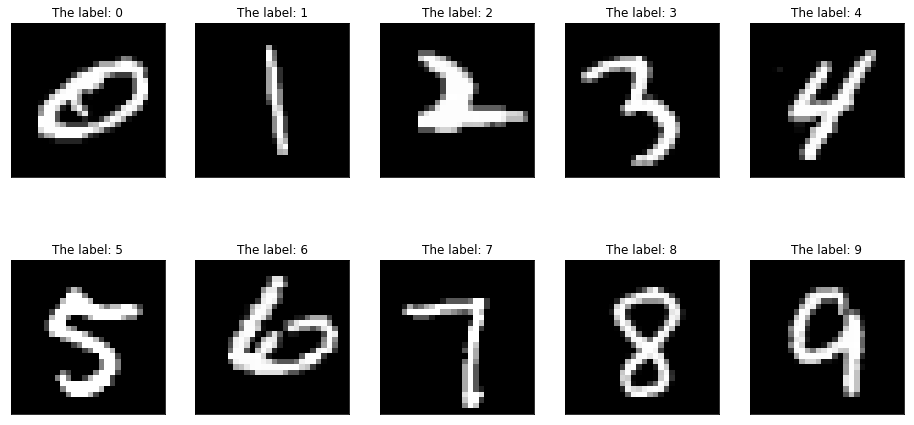

In [87]:
# Reconstructing sample images for different classes:

plt.figure(figsize = (16,8))
gridspec.GridSpec(2,5)

# Location of image on plt grid
loc = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]

# Index of numbers to lookup
index = [0, 12, 49, 2, 31, 41, 9, 32, 5, 7]

for i in range(10):
    plt.subplot2grid((2,5), loc[i])
    plt.imshow(X[index[i],:].reshape(28, 28), cmap='gray');
    plt.title(f'The label: {y[index[i]].astype(int)}');
    plt.xticks([])
    plt.yticks([])

We can also visualize the mean of each class as an average representation of each digit based on the entire dataset (training and test data):

In [88]:
y_digits = []
X_means = np.zeros((10, 784))

for digit in range(0, 10):
    y_digits.append(digit)
    X_filtered = X[y == digit]
    for pixel in range(0, 784):
        X_means[digit, pixel] = np.mean(X_filtered[:,pixel])

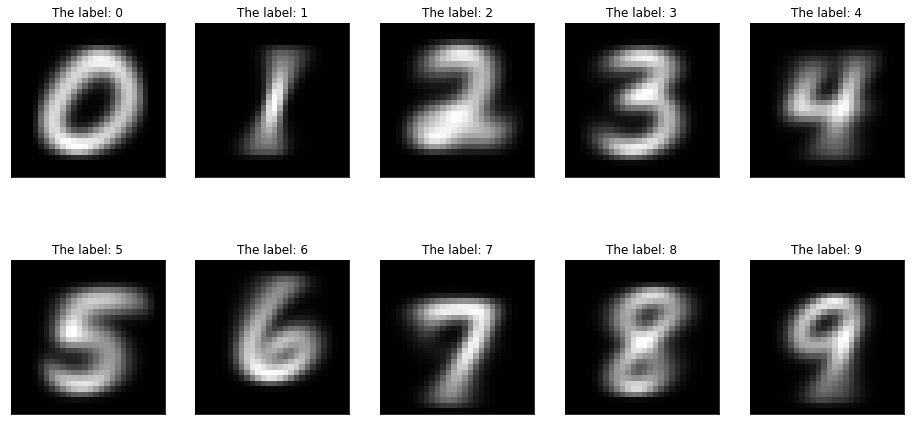

In [91]:
# Visualizing average representations of each class:

plt.figure(figsize = (16,8))
gridspec.GridSpec(2,5)

# Location of image on plt grid
loc = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]

for i in range(10):
    plt.subplot2grid((2,5), loc[i])
    plt.imshow(X_means[i,:].reshape(28, 28), cmap='gray');
    plt.title(f'The label: {y_digits[i]}');
    plt.xticks([])
    plt.yticks([])

Before proceeding, let's scale the data. We will use the Max-Min scaler to transform the features so that the values lie between 0 and 1. If $v$ is the value of a particular feature $x$ then we transform it by applying:

$$v^{new} = \frac{v^{old}-min(x)}{max(x)-min(x)}$$

Since for our image data Min is equal to 0 and Max is equal to 255, we practically need to divide values by max possible value, 255:

In [92]:
# Scaling all X values to values between 0 and 1 using a Max-Min Scaler

X_train = X_train / 255
X_test = X_test / 255

## 4. Modeling

Before we start, let's create an empty dataframe that we can use to populate the training and test accuracies as we try different models:

In [137]:
summary_table = pd.DataFrame()

### Logistic Regression:

Let's start by fitting a simple logistic regression model to this data. We will check the model's accuracy on both training and test sets, also check the computation time to compare with other models:

In [260]:
from sklearn.linear_model import LogisticRegression

start = time.time()

logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000,
                                 penalty='l2', C = 0.1, random_state = 1)
logit_model = logit_model.fit(X_train, y_train)

end = time.time()

# Populating the accuracies on our summary table:
summary_table.loc['Logistic Regression','Training Accuracy'] = logit_model.score(X_train,y_train)
summary_table.loc['Logistic Regression','Test Accuracy'] = logit_model.score(X_test,y_test)

print(f"It took {np.round(end-start, 1)} seconds to train the model")
print(f"The accuracy on training set is:\t{logit_model.score(X_train,y_train):0.2}")
print(f"The accuracy on test set is:\t\t{logit_model.score(X_test,y_test):0.2}")

It took 9.7 seconds to train the model
The accuracy on training set is:	0.93
The accuracy on test set is:		0.92


#### PCA for dimensionality reduction:
Let's reduce the dimensionality of the data using Principal Component Analysis (PCA) and see how that impacts the computation time:

In [142]:
from sklearn.decomposition import PCA

# Build and fit a PCA model to the data for 100 principal components
my_PCA = PCA(n_components = 100, random_state = 1).fit(X_train)
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

We now re-fit the logistic regression model, this time on the `X_train_PCA` data:

In [261]:
import time
start = time.time()

logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                 penalty='l2', C = 0.1, random_state = 1)
logit_model = logit_model.fit(X_train_PCA, y_train)

end = time.time()

# Populating the accuracies on our summary table:
summary_table.loc['Logistic Regression with PCA','Training Accuracy'] = logit_model.score(X_train_PCA,y_train)
summary_table.loc['Logistic Regression with PCA','Test Accuracy'] = logit_model.score(X_test_PCA,y_test)

print(f"It took {np.round(end-start, 1)} seconds to train the model")
print(f"The accuracy on training set is:\t{logit_model.score(X_train_PCA,y_train):0.2}")
print(f"The accuracy on test set is:\t\t{logit_model.score(X_test_PCA,y_test):0.2}")

It took 1.1 seconds to train the model
The accuracy on training set is:	0.92
The accuracy on test set is:		0.91


As shown above the computation reduces by a factor of 10 with minimal impact to the accuracy metric. Let's try reducing the data to different number of principal components and plot the computation time and accuracy:

In [96]:
# Trying different number of PCA components
n_range = [2, 10, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500, 700]

train_time = []
train_score = []
test_score = []

for n in n_range:
    my_PCA = PCA(n_components = n, random_state = 1).fit(X_train)
    X_train_PCA = my_PCA.transform(X_train)
    X_test_PCA = my_PCA.transform(X_test)
    
    start = time.time()

    logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                     penalty='l2', C = 0.1, random_state = 1)
    logit_model = logit_model.fit(X_train_PCA, y_train)

    end = time.time()
        
    train_time.append(end - start)
    train_score.append(logit_model.score(X_train_PCA, y_train))
    test_score.append(logit_model.score(X_test_PCA, y_test))
    
    # Displaying progress
    clear_output(wait = True)
    print(f'Trained for n = {n}')
clear_output()

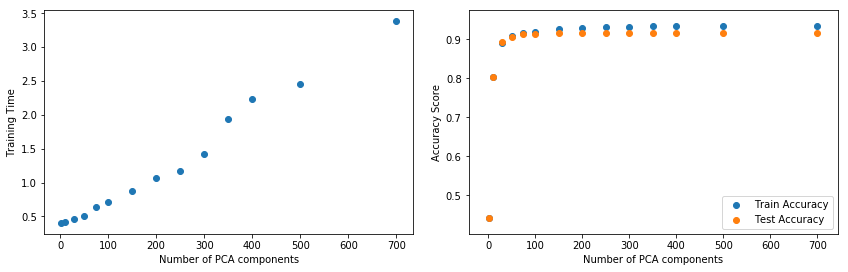

In [97]:
# Plotting the run-time and accuracy
plt.figure(figsize = (12,4))
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))
plt.scatter(n_range, train_time, label = 'Train Time');
plt.xlabel('Number of PCA components')
plt.ylabel('Training Time')

plt.subplot2grid((1,2), (0,1))
plt.scatter(n_range, train_score, label = 'Train Accuracy');
plt.scatter(n_range, test_score, label = 'Test Accuracy');
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy Score')
plt.legend();

plt.tight_layout(pad=1.5)

As shown above, reducing the dimensionality reduces the training time for the Logistic model. This is due to reduced number of computations that will be required on each datapoint (less features to train on). This may seem similar to reducing the number of training points - but let's re-fit the model on smaller subsets of data and see: 

In [109]:
# Trying different subsets of the training data
percentage = np.arange(0.1,1.0,0.1)

train_time = []
train_score = []
test_score = []
sample_size = []

for n in percentage:
    X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=n, stratify = y_train, random_state = 1)
        
    start = time.time()

    logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                         penalty='l2', C = 0.1, random_state = 1)
    logit_model = logit_model.fit(X_subset, y_subset)

    end = time.time()
    train_time.append(end - start)
    sample_size.append(n * X.shape[0])
    train_score.append(logit_model.score(X_subset, y_subset))
    test_score.append(logit_model.score(X_test, y_test))
    
    # Displaying progress
    clear_output(wait = True)
    print(f'Trained for n = {n}')
clear_output()

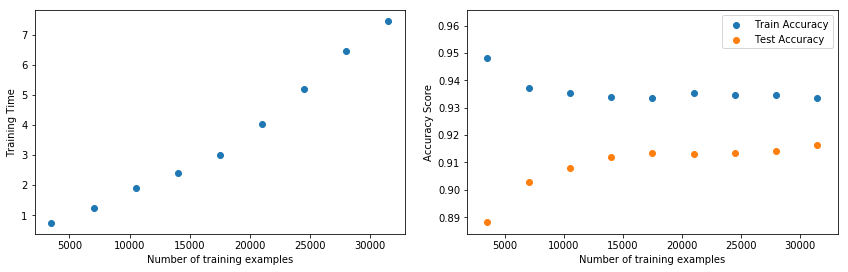

In [110]:
plt.figure(figsize = (12,4))
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))
plt.scatter(sample_size, train_time, label = 'Train Time');
plt.xlabel('Number of training examples')
plt.ylabel('Training Time')

plt.subplot2grid((1,2), (0,1))
plt.scatter(sample_size, train_score, label = 'Train Accuracy');
plt.scatter(sample_size, test_score, label = 'Test Accuracy');
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy Score')
plt.legend();

plt.tight_layout(pad=1.5)

It is shows that we may also reduce the computation time by training the model on smaller subsets of data (reducing the number of data points) but we must acknowledge that by reducing the number of training datapoints we increase the chance of overfitting (see accuracy results for low training points above).

The advantage of reducing dimensionality using PCA is that we can reduce the computation time with minimal impact on accuracy. Also, since the model will now have fewer degrees of freedom, the likelihood of overfitting is lower. However, reducing dimensionality still means losing some of the available data which may eventually impact the accuracy of our model.

On the other hand reducing the number of data points can be a quick and effective way for getting a representative sample of data for initial modeling, without losing any of the features. However by excluding available data points from training set we do not exhaust all our resources in training the model. This will also increase the chance of overfitting as the model have less examples to train on (reduced generalizability).

### K Nearest Neighbors

To start, let's train two KNN classifiers to model the data, one where `K=1` and one where `K=the number of training points`:

In [21]:
# training KNN classifier to model the data where K = 1 
KNN_model = KNeighborsClassifier(n_neighbors = 1)
KNN_model.fit(X_train, y_train)

print(f"The accuracy on training set is:\t{KNN_model.score(X_train,y_train):0.2}")
print(f"The accuracy on test set is:\t\t{KNN_model.score(X_test,y_test):0.2}")

The accuracy on training set is:	1.0
The accuracy on test set is:		0.96


As expected the model with `K = 1` performs very well on the training data that it has seen (memorized) with 100% accurate predictions, but accuracy drops when it tries to predict the unseen test data.

In [22]:
# training KNN classifier to model the data where K = m_train 
KNN_model = KNeighborsClassifier(n_neighbors = m_train)
KNN_model.fit(X_train, y_train)

print(f"The accuracy on training set is:\t{KNN_model.score(X_train,y_train):0.2}")
print(f"The accuracy on test set is:\t\t{KNN_model.score(X_test,y_test):0.2}")

The accuracy on training set is:	0.11
The accuracy on test set is:		0.11


This time, with `K = number of training points`, we get a much lower accuracy. With 10 classes (assuming uniform distribution of all 10 digits in our dataset) the accuracy of a model that predicts solely by chance is about 100/10 = 10%. Our model here performs almost as bad, since in practice the KNN model with `K = number of training points` predicts all points to be of the majority class.

Let's run the model with different K values between `K = 1` and `K = number of training points`:

In [146]:
K = [2, 4, 6, 8, 10, 15, 20, 50, 100, 200, 500, 1000]
train_accuracy = []
test_accuracy = []

for k in K:
    
    KNN_model = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    train_accuracy.append(KNN_model.score(X_train, y_train))
    test_accuracy.append(KNN_model.score(X_test,y_test))

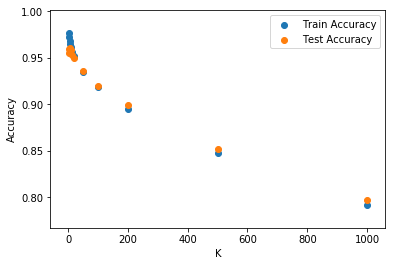

In [147]:
# Plotting accuracy vs. K value for the KNN models:
plt.scatter(K, train_accuracy, label = 'Train Accuracy');
plt.scatter(K, test_accuracy, label = 'Test Accuracy');
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend();

Let's focus on the K values between 0 and 20:

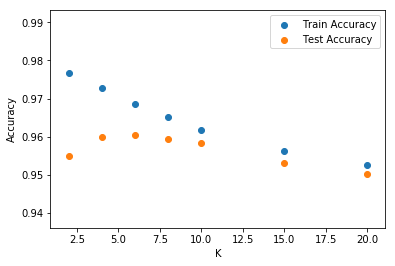

In [148]:
plt.scatter(K[0:7], train_accuracy[0:7], label = 'Train Accuracy');
plt.scatter(K[0:7], test_accuracy[0:7], label = 'Test Accuracy');
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend();

As shown above the accuracy of the model on training data decreases as the value of K increases (more generalized model) while the model accuracy on test data increases (less overfitting) up to a point from where both accuracies start declining as the value of K increases (in extreme case the model will predict the majority class if k = number of training data). In order to get the best performance from the model we set the K (number of neighbours that the KNN model will use) to the value that gives maximum `test_accuracy`:

In [149]:
# Finding the K where test_accuracy was maximum
opt_k = K[test_accuracy.index(max(test_accuracy))]

In [150]:
# Populating the accuracies on our summary table:
summary_table.loc['KNN','Training Accuracy'] = train_accuracy[test_accuracy.index(max(test_accuracy))]
summary_table.loc['KNN','Test Accuracy'] = test_accuracy[test_accuracy.index(max(test_accuracy))]

print(f"Using optimum value for K:\t\t{opt_k}")
print(f"The accuracy on training set is:\t{train_accuracy[test_accuracy.index(max(test_accuracy))]:0.3}")
print(f"The accuracy on test set is:\t\t{test_accuracy[test_accuracy.index(max(test_accuracy))]:0.3}")

Using optimum value for K:		6
The accuracy on training set is:	0.969
The accuracy on test set is:		0.961


### Decision Trees

As another classification model that can be used on our data, let's use a decision tree. This time we can control the model by either its `max_depth` or `min_samples_leaf`:

In [28]:
# Allowing the model to choose max_depth:
DT_model = DecisionTreeClassifier(random_state = 1)
DT_model.fit(X_train, y_train)

print(f"The accuracy on training set is:\t{DT_model.score(X_train,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{DT_model.score(X_test,y_test):0.3}")

The accuracy on training set is:	1.0
The accuracy on test set is:		0.842


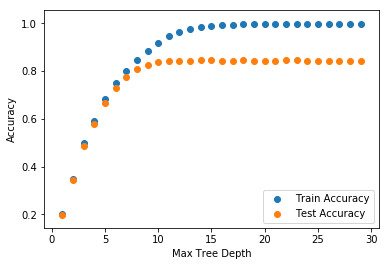

In [113]:
# Trying different max_depth for the decision tree
max_depth = range(1,30)
train_accuracy = []
test_accuracy = []

for depth in max_depth:
    DT_model = DecisionTreeClassifier(max_depth = depth, random_state = 1)
    DT_model.fit(X_train, y_train)
    train_accuracy.append(DT_model.score(X_train,y_train))
    test_accuracy.append(DT_model.score(X_test,y_test))
    
    # Displaying progress
    clear_output(wait = True)
    print(f'DT trained for max_depth = {depth}')

clear_output()
    
plt.scatter(max_depth, train_accuracy, label = 'Train Accuracy');
plt.scatter(max_depth, test_accuracy, label = 'Test Accuracy');
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend();

As expected, by reducing the `max_depth` to very low values, we limit our model's learning. However, as the tree depth increases the model reaches a point where increasing the tree depth no longer improve the model's train or test accuracy. It is also worth noting that as the depth increases, the gap between train and test accuracy increases, which shows higher degree of overfitting in the model.

In [30]:
# Finding the tree depth where test_accuracy was maximum
opt_depth = max_depth[test_accuracy.index(max(test_accuracy))]

In [151]:
# Using the tree depth where test_accuracy was maximum:
DT_model = DecisionTreeClassifier(max_depth = opt_depth, random_state = 1)
DT_model.fit(X_train, y_train)

# Populating the accuracies on our summary table:
summary_table.loc['Decision Tree','Training Accuracy'] = DT_model.score(X_train,y_train)
summary_table.loc['Decision Tree','Test Accuracy'] = DT_model.score(X_test,y_test)

print(f"Using optimum value for max_depth:\t{opt_depth}")
print(f"The accuracy on training set is:\t{DT_model.score(X_train,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{DT_model.score(X_test,y_test):0.3}")

Using optimum value for max_depth:	14
The accuracy on training set is:	0.986
The accuracy on test set is:		0.846


Before moving on let's see if tuning the model using the `min_samples_leaf` gives us any different results:

DT trained for min_samples_leaf = 29


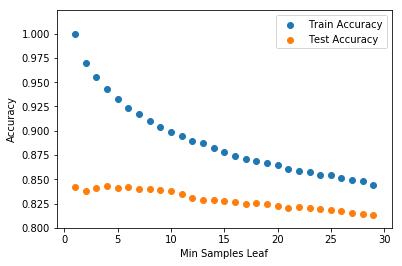

In [32]:
# Trying different min_samples_leaf for the decision tree
min_samples_leaf = range(1,30)
train_accuracy = []
test_accuracy = []

for min_sample in min_samples_leaf:
    DT_model = DecisionTreeClassifier(min_samples_leaf = min_sample, random_state = 1)
    DT_model.fit(X_train, y_train)
    train_accuracy.append(DT_model.score(X_train,y_train))
    test_accuracy.append(DT_model.score(X_test,y_test))
    clear_output(wait = True)
    print(f'DT trained for min_samples_leaf = {min_sample}')
    
plt.scatter(min_samples_leaf, train_accuracy, label = 'Train Accuracy');
plt.scatter(min_samples_leaf, test_accuracy, label = 'Test Accuracy');
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend();

Similarly we can see more overfitting in the model as the `min_samples_leaf` reduces.

In [33]:
# Finding the min_samples_leaf where test_accuracy was maximum
opt_min_samples_leaf = min_samples_leaf[test_accuracy.index(max(test_accuracy))]

In [117]:
# Using the min_samples_leaf where test_accuracy was maximum
DT_model = DecisionTreeClassifier(min_samples_leaf = opt_min_samples_leaf, random_state = 1)
DT_model.fit(X_train, y_train)

print(f"Using optimum value for min_samples_leaf:\t{opt_min_samples_leaf}")
print(f"The accuracy on training set is:\t\t{DT_model.score(X_train,y_train):0.3}")
print(f"The accuracy on test set is:\t\t\t{DT_model.score(X_test,y_test):0.3}")

Using optimum value for min_samples_leaf:	4
The accuracy on training set is:		0.943
The accuracy on test set is:			0.843


### Logistic Regression with Cross-Validation

Let's go back to the first model and see if we can optimize its hyperparameters. For this reason we will use 5-fold cross-validation and describe the findings.

Let's first use PCA and reduce the data dimensionality to 100 principle components (see above for more details):

In [35]:
# Build and fit a PCA model to the data for 100 principal components
my_PCA = PCA(n_components = 100, random_state = 1).fit(X_train)
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

We can now use scikit-learn's `cross_val_score` to find the optimum hyperparameter C (inverse of regularization strength):

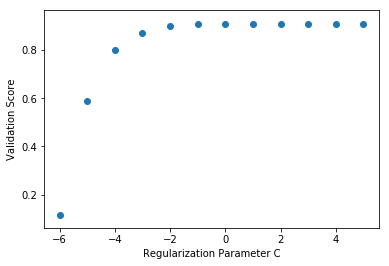

In [36]:
from sklearn.model_selection import cross_val_score

validation_score_list = []

C = [10**n for n in range(-6,6)]

for c in C :
    logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                     penalty='l2', C = c, random_state = 1)

    validation_score = np.mean(cross_val_score(logit_model, X_train_PCA, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
plt.scatter(np.log10(C), validation_score_list)
plt.xlabel('Regularization Parameter C')
plt.ylabel('Validation Score')
plt.show();

In [262]:
# Finding the Regularization Parameter C where cross-validation accuracy was maximum
opt_c = C[validation_score_list.index(max(validation_score_list))]

logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                 penalty='l2', C = opt_c, random_state = 1)
logit_model = logit_model.fit(X_train_PCA, y_train)

# Populating the accuracies on our summary table:
summary_table.loc['Logistic Regression with CV','Training Accuracy'] = logit_model.score(X_train_PCA,y_train)
summary_table.loc['Logistic Regression with CV','Test Accuracy'] = logit_model.score(X_test_PCA,y_test)

print(f"Using optimum value for C:\t\t{opt_c}")
print(f"The accuracy on training set is:\t{logit_model.score(X_train_PCA,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{logit_model.score(X_test_PCA,y_test):0.3}")

Using optimum value for C:		1
The accuracy on training set is:	0.924
The accuracy on test set is:		0.917


The regularization parameter C is the inverse of the regularization strength, which means the lower the C value the higher regularization, and hence less overfitting in our model. 

We can also re-visit the number of principle components for PCA (as a hyperparameter) using the cross-validation approach:

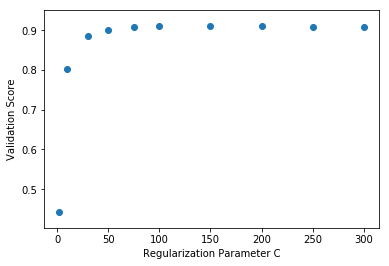

In [38]:
validation_score_list = []

n_range = [2, 10, 30, 50, 75, 100, 150, 200, 250, 300]

for n in n_range:
    my_PCA = PCA(n_components = n, random_state = 1).fit(X_train)
    X_train_PCA = my_PCA.transform(X_train)
    X_test_PCA = my_PCA.transform(X_test)

    logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                     penalty='l2', C = 1, random_state = 1)

    validation_score = np.mean(cross_val_score(logit_model, X_train_PCA, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
plt.scatter(n_range, validation_score_list)
plt.xlabel('Regularization Parameter C')
plt.ylabel('Validation Score')
plt.show();

In [39]:
# Finding the number of components where cross-validation accuracy was maximum
opt_n = n_range[validation_score_list.index(max(validation_score_list))]

my_PCA = PCA(n_components = opt_n, random_state = 1).fit(X_train)
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

logit_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                                 penalty='l2', C = 1, random_state = 1)
logit_model = logit_model.fit(X_train_PCA, y_train)

print(f"Using optimum number of components :\t{opt_n}")
print(f"The accuracy on training set is:\t{logit_model.score(X_train_PCA,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{logit_model.score(X_test_PCA,y_test):0.3}")

Using optimum number of components :	150
The accuracy on training set is:	0.931
The accuracy on test set is:		0.917


Let's have a look at the confusion matrix for this model:

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, logit_model.predict(X_test_PCA))
print(conf_matrix)

[[1334    0    8    4    1   15    9    1    7    4]
 [   0 1512    4    6    0    5    1    2   12    3]
 [   6   21 1218   34   17    7   24   21   31    9]
 [   9   10   28 1293    2   44    4   17   26    6]
 [   1    8   13    2 1253    1   20    7   10   57]
 [  13   10   13   37   15 1115   28    5   34   16]
 [   8    4    9    0    9   35 1306    1    4    1]
 [   8   10   19    6   15    2    1 1374    1   44]
 [   8   22   14   33   11   40   13    3 1198   16]
 [   6    9    3   13   36    7    0   49   16 1233]]


We can make a more clear representation of the confusion matrix by plotting the values on a heatmap. We will mask the "True Positives" for all classes (main diagonal values) as they have much higher values than the off-diagonal values and would make the visualization less useful:

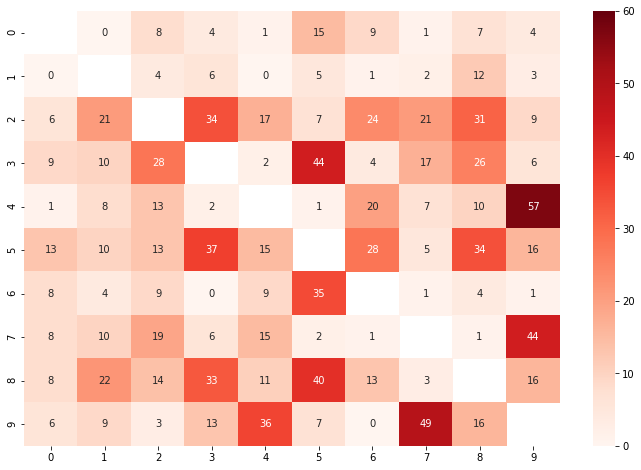

In [41]:
plt.figure(figsize = (12,8))
sns.heatmap(conf_matrix, annot=True, mask = (conf_matrix > 100), vmax=60, cmap = 'Reds');

As we can see the number of incorrect predictions is different for each digit. It is also interesting to see a considerable degree of symmetry in the matrix, e.g. we have a high number of 4's predicted as 9 and a high number of 9's predicted as 4. This can be explained by the fact that these two numbers have many similar features in the handwritten examples.

Let's now focus on our specific example above and see if re-fitting a linear model, this time only on the digits 4 and 9 can give us any interesting insight into why/how the classifier confuses the two.

To do this, we filter the dataset to only contain 4's and 9's, then fit a Logistic Regression model:

In [254]:
# Filtering the entire dataset into 4's and 9's only:
X49 = X[(y == 4) | (y == 9)].copy()
y49 = y[(y == 4) | (y == 9)].copy()

# Training a logistic regression model into the subset of 4's and 9's:
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=100, penalty='l2', C=1e-10, random_state = 1)
logit_model = logit_model.fit(X49, y49)

# We do not really care about the accuracy of this model, but just in case:
print(f"The accuracy on training set is: {logit_model.score(X49, y49):0.3}")

The accuracy on training set is: 0.847


Now let's visualize the absolute value of weights (coefficients) of the model as an image:

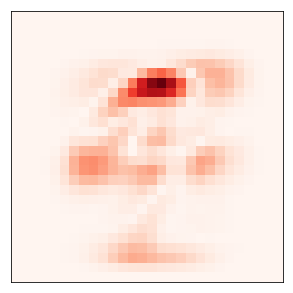

In [255]:
# Visualization of the absolute value of weights (coefficients) of the model as an image
plt.figure(figsize = (5,5))
plt.imshow(np.abs(logit_model.coef_[0,:]).reshape(28, 28), cmap='Reds');
plt.xticks([])
plt.yticks([]);

The image shows the absolute value of the regression coefficients for the model that we trained to predict only 4's and 9's, where the darker red represents a higher absolute value for the coefficient of that pixel (aka feature). In other words, the points with darker red color have more impact on the outcome (prediction) of the logistic regression and are the features that contribute the most to model's prediction. This becomes even more interesting when we put this image besides an average image of 4 and an average image of 9. 

As shown below, the points with higher coefficients correspond to the main differences between an average handwritten digit 4 and 9 (the 3 circled areas show 3 sample areas that usually differ bertween 4 and 9):

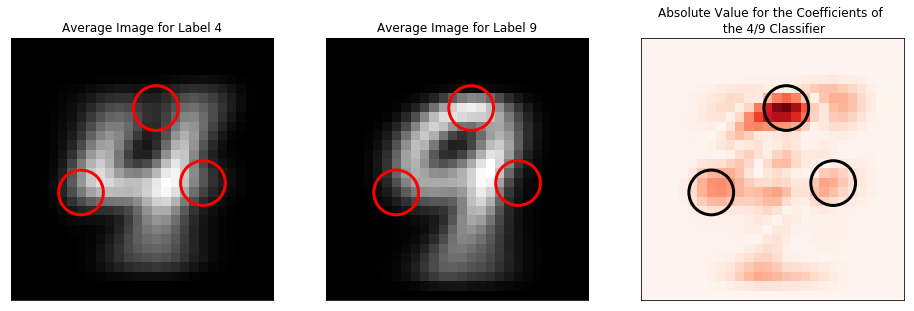

In [256]:
plt.figure(figsize = (16,5))
gridspec.GridSpec(1,3)

# An average representation of number 4:
plt.subplot2grid((1,3), (0,0))
plt.imshow(X_means[4,:].reshape(28, 28), cmap='gray');
plt.title(f'Average Image for Label {y_digits[4]}');
plt.xticks([])
plt.yticks([])
plt.scatter(15, 7, s=2000, marker='o', facecolors='none', edgecolors='r', linewidth=3);
plt.scatter(7, 16, s=2000, marker='o', facecolors='none', edgecolors='r', linewidth=3);
plt.scatter(20, 15, s=2000, marker='o', facecolors='none', edgecolors='r', linewidth=3);

# An average representation of number 9
plt.subplot2grid((1,3), (0,1))
plt.imshow(X_means[9,:].reshape(28, 28), cmap='gray');
plt.title(f'Average Image for Label {y_digits[9]}');
plt.xticks([])
plt.yticks([])
plt.scatter(15, 7, s=2000, marker='o', facecolors='none', edgecolors='r', linewidth=3);
plt.scatter(7, 16, s=2000, marker='o', facecolors='none', edgecolors='r', linewidth=3);
plt.scatter(20, 15, s=2000, marker='o', facecolors='none', edgecolors='r', linewidth=3);

# Visualization of the absolute value of weights (coefficients) of the model as an image
plt.subplot2grid((1,3), (0,2))
plt.imshow(np.abs(logit_model.coef_[0,:]).reshape(28, 28), cmap='Reds');
plt.title(f'Absolute Value for the Coefficients of \n the 4/9 Classifier');
plt.xticks([])
plt.yticks([]);
plt.scatter(15, 7, s=2000, marker='o', facecolors='none', edgecolors='black', linewidth=3);
plt.scatter(7, 16, s=2000, marker='o', facecolors='none', edgecolors='black', linewidth=3);
plt.scatter(20, 15, s=2000, marker='o', facecolors='none', edgecolors='black', linewidth=3);

Before wrapping up, let's train a few more models on this dataset and see if we can get a model with higher prediction accuracy:

### Random Forests
As an ensemble model, let's try training a RandomForests model on the training data:

In [153]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=1000, max_depth = 100, random_state = 1)
random_forest.fit(X_train, y_train)

# Populating the accuracies on our summary table:
summary_table.loc['Random Forests','Training Accuracy'] = random_forest.score(X_train,y_train)
summary_table.loc['Random Forests','Test Accuracy'] = random_forest.score(X_test,y_test)

print(f"The accuracy on training set is:\t{random_forest.score(X_train,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{random_forest.score(X_test,y_test):0.3}")

The accuracy on training set is:	1.0
The accuracy on test set is:		0.962


And also a quick look at the confusion matrix:

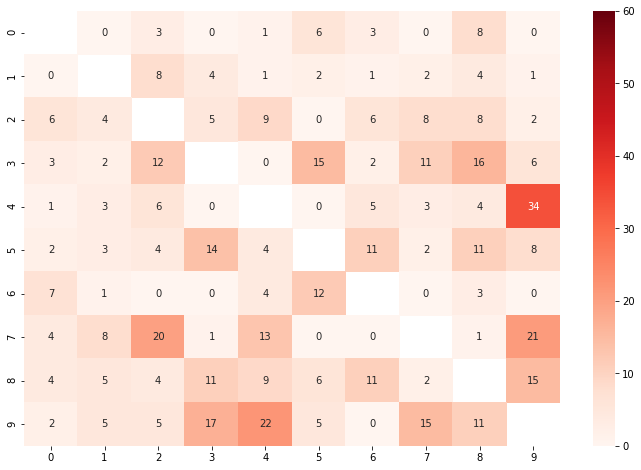

In [49]:
conf_matrix = confusion_matrix(y_test, random_forest.predict(X_test))

plt.figure(figsize = (12,8))
sns.heatmap(conf_matrix, annot=True, mask = (conf_matrix > 100), vmax=60, cmap = 'Reds');

No big surprise that numbers 4 and 9 still have a large number of incorrect predictions by this new model.

### Support Vector Machines
We continue with training a Support Vector Classifier on the training data:

In [45]:
from sklearn.svm import SVC

my_kernel_SVM = SVC(kernel='rbf', gamma = 0.05, C = 5, random_state = 1)
my_kernel_SVM.fit(X_train, y_train)

# Populating the accuracies on our summary table:
summary_table.loc['SVM','Training Accuracy'] = my_kernel_SVM.score(X_train,y_train)
summary_table.loc['SVM','Test Accuracy'] = my_kernel_SVM.score(X_test,y_test)

print(f"The accuracy on training set is:\t{my_kernel_SVM.score(X_train,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{my_kernel_SVM.score(X_test,y_test):0.3}")

The accuracy on training set is:	1.0
The accuracy on test set is:		0.977


A pretty good accuracy! Let's have a quick look at the confusion matrix:

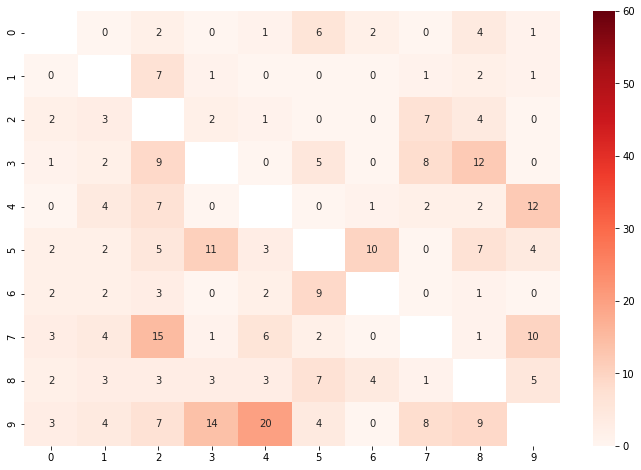

In [46]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, my_kernel_SVM.predict(X_test))

plt.figure(figsize = (12,8))
sns.heatmap(conf_matrix, annot=True, mask = (conf_matrix > 100), vmax=60, cmap = 'Reds');

Despite the increase in accuracy, a large number of incorrect predictions are still on digits 4 and 9.

### Gradient Boosting Classifier
And finally let's fit a Gradient Boosting Classifier:

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

my_GB = GradientBoostingClassifier(learning_rate = 0.1, n_estimators=500, random_state = 1, verbose = 2)
my_GB.fit(X_train, y_train)

# Populating the accuracies on our summary table:
summary_table.loc['Gradient Boosting','Training Accuracy'] = my_GB.score(X_train,y_train)
summary_table.loc['Gradient Boosting','Test Accuracy'] = my_GB.score(X_test,y_test)

print(f"The accuracy on training set is:\t{my_GB.score(X_train,y_train):0.3}")
print(f"The accuracy on test set is:\t\t{my_GB.score(X_test,y_test):0.3}")

The accuracy on training set is:	1.0
The accuracy on test set is:		0.959


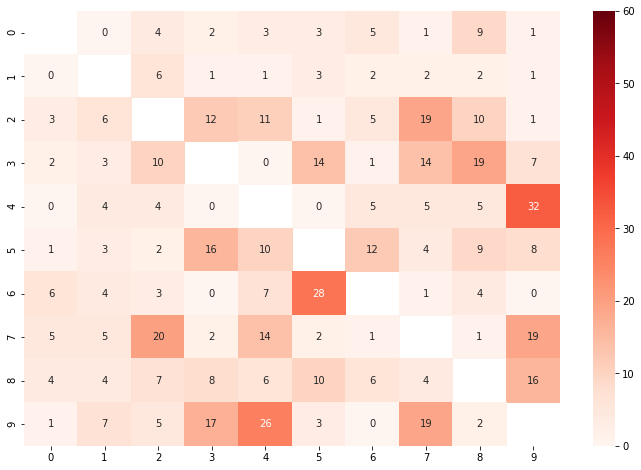

In [56]:
conf_matrix = confusion_matrix(y_test, my_GB.predict(X_test))

plt.figure(figsize = (12,8))
sns.heatmap(conf_matrix, annot=True, mask = (conf_matrix > 100), vmax=60, cmap = 'Reds');

No big difference from the other models where some digits show higher number of incorrect predictions.

## Summary

Now that we have trained a few different models let's have a look at the summary table that we were populating all along the way:

In [266]:
summary_table_sorted = round(summary_table.sort_values(by = 'Test Accuracy', ascending=False), 3)
display(summary_table_sorted)

,Training Accuracy,Test Accuracy
SVM,1.000,0.977
Random Forests,1.000,0.962
KNN,0.969,0.961
Gradient Boosting,1.000,0.959
Logistic Regression with CV,0.924,0.917
Logistic Regression,0.934,0.916
Logistic Regression with PCA,0.919,0.914
Decision Tree,0.986,0.846


The table is sorted by the test accuracy values that we've got from the models. With the SVM model having the highest test accuracy, we pick this model as the best fit for the MNIST dataset and export it as a .pkl file:

In [251]:
from sklearn.externals import joblib
joblib.dump(my_kernel_SVM, 'my_SVM_model.pkl');